__PyTorch: Data loading and processing tutorial__

1. [Import](#Import)
1. [Review dataset](#Review-dataset)
1. [Dataset class](#Dataset-class)
1. [Custom transforms](#Custom-transforms)
    1. [Rescale](#Rescale)
    1. [RandomCrop](#RandomCrop)
    1. [ToTensor](#ToTensor)
    1. [Compose the transforms](#Compose-the-transforms)
    1. [Iterate through the entire dataset](#Iterate-through-the-entire-dataset)
1. [DataLoader](#DataLoader)

# Import

<a id = 'Import'></a>

In [1]:
#
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings

warnings.filterwarnings("ignore")

plt.ion()

# Review dataset

<a id = 'Review-dataset'></a>

In [16]:
# read csv containing landmark annotations. store in (n, 2) array where n is the # of landmarks
landmarks_frame = pd.read_csv("/main/tmp/faces/face_landmarks.csv")
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()

# reshape to store arbitrary number of pairs of x/y coordinates of landmarks
landmarks = landmarks.astype("float").reshape(-1, 2)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 landmarks: {}".format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


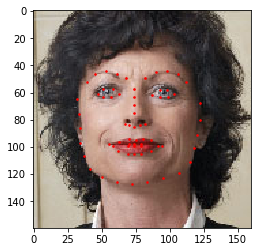

In [19]:
# helper function to show an image and its landmarks
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker=".", c="r")
    plt.pause(0.001)


plt.figure()
show_landmarks(io.imread(os.path.join("/main/tmp/faces/", img_name)), landmarks)

# Dataset class

torch.utils.data.Dataset is an abstract class that represents a dataset. A custom dataset should inherit Dataset and override the following methods:

- __len__ - so that len(dataset) returns the size of the custom dataset
- __getitem__ - to support indexing so that dataset[i] returns the ith example.

We want to read the csv in the \_\_init\_\_ method and reading the images in \_\_getitem\_\_. This is more memory efficient because we're not storing all images in memory but instead reading as required.

<a id = 'Dataset class'></a>

In [27]:
#
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype("float").reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


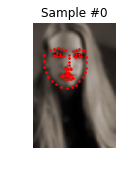

1 (500, 333, 3) (68, 2)


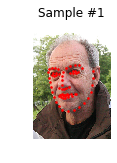

2 (250, 258, 3) (68, 2)


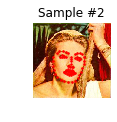

3 (434, 290, 3) (68, 2)


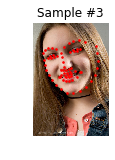

In [29]:
# instantiate the class and iterate through a few sample
face_dataset = FaceLandmarksDataset(
    csv_file="/main/tmp/faces/face_landmarks.csv", root_dir="/main/tmp/faces/"
)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample["image"].shape, sample["landmarks"].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# Custom transforms

Neural networks expect the input images to be a fixed size. The implementations below are callable classes. To mae this happen, we need to implement a call method and if required an init method

<a id = 'Custom transforms'></a>

## Rescale

<a id = 'Rescale'></a>

In [ ]:
#
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmakrs = sample["image"], sample["landmarks"]

        h, w = image.shape[2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # swap h and w - x and y axes in images are axis 1 and 0, respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        return {"image": img, "landmarks": landmarks}

## RandomCrop

<a id = 'RandomCrop'></a>

In [ ]:
#
class RandomCrop:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top : top + new_h, left : left + new_w]

        landmarks = landmarks = [left, top]

        return {"image": image, "landmarks": landmarks}

## ToTensor

<a id = 'ToTensor'></a>

In [ ]:
#
class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        # swap color axes because indexing:
        # numpy image = H by W by C
        # torch image = C by H by W
        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "landmarks": torch.from_numpy(landmarks),
        }

## Compose the transforms

Apply the above transforms on a sample to rescale the short side of the image to 256 and then randomly crop out a square of size 224. the utility torchvision.transforms.Compose is a builtin callable class that enables this

<a id = 'Compose-the-transforms'></a>

In [ ]:
#
scale = Rescale(256)
crop = RandomCrop(128)
compose = torchvision.transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_Dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterate through the entire dataset

The downside of this initial approach below is that we cannot batch the data, shuffle the data, or load the data in parallel.

The subsequent block utilizes torch.utils.data.DataLoader, which is an iterator that has all of these features.

<a id = 'Iterate through the entire dataset'></a>

In [ ]:
# inefficient approach
transformed_dataset = FaceLandmarksDataset(
    csv_file="",
    root_dir="",
    transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]),
)
for i in range(len(transformed_dataset)):
    sample = transformed_Dataset[i]

    print(i, sample["image"].size(), sample["landmarks"].size())
    if i == 3:
        break

In [ ]:
# correct approach
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

# helper function to visualize batch
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = sample_batched["image"], sample_batched["landmarks"]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy(), transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(
            landmarks_batch[i, :, 0].numpy() + i * im_show,
            landmarks_batch[i, :, 1].numpy(),
            s=10,
            markers=".",
            c="r",
        )
        plt.title("batch from dataloader")

    for i_batch, sample_batched in enuemrate(dataloader):
        print(
            i_batch, sample_batched["image"].size(), sample_batched["landmarks"].size()
        )

        if i_batch == 3:
            plt.figure()
            show_landmarks_batch(sample_batched)
            plt.axis("off")
            plt.ioff()
            plt.show()
            break

# DataLoader

PyTorch has several builtin transformers. The implementation below leverages a few.

<a id = 'DataLoader'></a>

In [ ]:
# DataLoader example
data_transform = transforms.Compose(
    [
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
hymenoptera_dataset = datasets.ImageFolder(
    root="hymenoptera_data/train", transform=data_transform
)
dataset_loader = torch.utils.data.DataLoader(
    hymenoptera_dataset, batch_size=4, shuffle=True, num_workers=4
)